In [6]:
import argparse
import errno
import os
import random
from importlib.metadata import requires
from timeit import timeit
import dill as pickle
import numpy as np
import scipy
import torch
import wandb
import yaml
from sympy import Matrix, MatrixSymbol, derive_by_array, symarray
from torch.distributions import Categorical

from subrl.utils.environment import GridWorld
from subrl.utils.network import append_state
from subrl.utils.network import policy as agent_net
from subrl.utils.visualization import Visu

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
workspace = "subrl"

params = {
    "env": {
        "start": 1,
        "step_size": 0.1,
        "shape": {"x": 7, "y": 14},
        "horizon": 40,
        "node_weight": "constant",
        "disc_size": "small",
        "n_players": 3,
        "Cx_lengthscale": 2,
        "Cx_noise": 0.001,
        "Fx_lengthscale": 1,
        "Fx_noise": 0.001,
        "Cx_beta": 1.5,
        "Fx_beta": 1.5,
        "generate": False,
        "env_file_name": 'env_data.pkl',
        "cov_module": 'Matern',
        "stochasticity": 0.0,
        "domains": "two_room",
        "num": 1  # 替代原来的args.env
    },
    "alg": {
        "gamma": 1,
        "type": "NM",
        "ent_coef": 0.0,
        "epochs": 140,
        "lr": 0.02
    },
    "common": {
        "a": 1,
        "subgrad": "greedy",
        "grad": "pytorch",
        "algo": "both",
        "init": "deterministic",
        "batch_size": 3000
    },
    "visu": {
        "wb": "disabled",
        "a": 1
    }
}

print(params)

# 2) Set the path and copy params from file
env_load_path = workspace + \
    "/environments/" + params["env"]["node_weight"]+ "/env_" + \
    str(params["env"]["num"])



epochs = params["alg"]["epochs"]

H = params["env"]["horizon"]
MAX_Ret = 2*(H+1)
if params["env"]["disc_size"] == "large":
    MAX_Ret = 3*(H+2)

# 3) Setup the environement
env = GridWorld(
    env_params=params["env"], common_params=params["common"], visu_params=params["visu"], env_file_path=env_load_path)
node_size = params["env"]["shape"]['x']*params["env"]["shape"]['y']
# TransitionMatrix = torch.zeros(node_size, node_size)

if params["env"]["node_weight"] == "entropy" or params["env"]["node_weight"] == "steiner_covering" or params["env"]["node_weight"] == "GP": 
    a_file = open(env_load_path +".pkl", "rb")
    data = pickle.load(a_file)
    a_file.close()

if params["env"]["node_weight"] == "entropy":
    env.cov = data
if params["env"]["node_weight"] == "steiner_covering":
    env.items_loc = data
if params["env"]["node_weight"] == "GP":
    env.weight = data

visu = Visu(env_params=params["env"])

env.get_horizon_transition_matrix()




{'env': {'start': 1, 'step_size': 0.1, 'shape': {'x': 7, 'y': 14}, 'horizon': 40, 'node_weight': 'constant', 'disc_size': 'small', 'n_players': 3, 'Cx_lengthscale': 2, 'Cx_noise': 0.001, 'Fx_lengthscale': 1, 'Fx_noise': 0.001, 'Cx_beta': 1.5, 'Fx_beta': 1.5, 'generate': False, 'env_file_name': 'env_data.pkl', 'cov_module': 'Matern', 'stochasticity': 0.0, 'domains': 'two_room', 'num': 1}, 'alg': {'gamma': 1, 'type': 'NM', 'ent_coef': 0.0, 'epochs': 140, 'lr': 0.02}, 'common': {'a': 1, 'subgrad': 'greedy', 'grad': 'pytorch', 'algo': 'both', 'init': 'deterministic', 'batch_size': 3000}, 'visu': {'wb': 'disabled', 'a': 1}}
x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001]
y_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999,

In [10]:
def sample_excellent_trajectories(filepath="go_explore_archive_spacetime_10m.pkl", 
                                  method='top_n', 
                                  n=10, 
                                  p=0.1, 
                                  threshold=0):
    """
        Load data from the Go-Explore archive and sample high-quality trajectories based on the specified method.

        Args:
            filepath (str): Path to the .pkl archive file.
            method (str): Sampling method. Options are 'top_n', 'top_p', or 'threshold'.
            n (int): Number of trajectories to sample for the 'top_n' method.
            p (float): Percentage of top trajectories to sample for the 'top_p' method (e.g., 0.1 means top 10%).
            threshold (float): Minimum reward threshold for the 'threshold' method.
        
        Returns:
            list: A list of trajectory dictionaries with high rewards, sorted in descending order of reward.
                  Returns an empty list if the file does not exist or the archive is empty.
    """
    # 1. Check if the file exists and load the data
    if not os.path.exists(filepath):
        print(f"Error: Archive file not found '{filepath}'")
        return []
    
    try:
        with open(filepath, "rb") as f:
            archive = pickle.load(f)
        if not archive:
            print("警告：存檔庫為空。")
            return []
    except Exception as e:
        print(f"讀取文件時出錯: {e}")
        return []

    # 2. 提取所有軌跡數據並按獎勵排序
    # archive.values() 返回的是包含 reward, states, actions 等信息的字典
    all_trajectories_data = list(archive.values())
    
    # 按 'reward' 鍵從高到低排序
    all_trajectories_data.sort(key=lambda x: x['reward'], reverse=True)

    # 3. 根據指定方法進行採樣
    sampled_trajectories = []
    if method == 'top_n':
        # 取獎勵最高的前 N 條
        num_to_sample = min(n, len(all_trajectories_data))
        sampled_trajectories = all_trajectories_data[:num_to_sample]
        print(f"方法: Top-N。從 {len(all_trajectories_data)} 條軌跡中篩選出最好的 {len(sampled_trajectories)} 條。")

    elif method == 'top_p':
        # 取獎勵最高的前 P%
        if not (0 < p <= 1):
            print("錯誤：百分比 'p' 必須在 (0, 1] 之間。")
            return []
        num_to_sample = int(len(all_trajectories_data) * p)
        sampled_trajectories = all_trajectories_data[:num_to_sample]
        print(f"方法: Top-P。從 {len(all_trajectories_data)} 條軌跡中篩選出最好的前 {p*100:.1f}% ({len(sampled_trajectories)} 條)。")

    elif method == 'threshold':
        # 取獎勵高於指定門檻的所有軌跡
        sampled_trajectories = [data for data in all_trajectories_data if data['reward'] >= threshold]
        print(f"方法: Threshold。從 {len(all_trajectories_data)} 條軌跡中篩選出 {len(sampled_trajectories)} 條獎勵不低於 {threshold} 的軌跡。")
        
    else:
        print(f"錯誤：未知的採樣方法 '{method}'。請使用 'top_n', 'top_p', 或 'threshold'。")

    return sampled_trajectories


In [11]:
top_20_trajectories = sample_excellent_trajectories(method='top_n', n=100)
if top_20_trajectories:
    print(f"其中最好的一條獎勵為: {top_20_trajectories[0]['reward']}")
    print(f"最差的一條（在這20條中）獎勵為: {top_20_trajectories[-1]['reward']}\n")

方法: Top-N。從 2312 條軌跡中篩選出最好的 100 條。
其中最好的一條獎勵為: 68
最差的一條（在這20條中）獎勵為: 64



In [21]:
def create_path_with_timesteps(states):
    """
    从轨迹数据创建带时间步的路径
    """
    # 将状态转换为带时间步的格式
    path_with_time = [(t, state.item()) for t, state in enumerate(states)]
    return path_with_time
path = create_path_with_timesteps(top_20_trajectories[11]["states"])
print(path)

[(0, 34), (1, 33), (2, 32), (3, 31), (4, 30), (5, 44), (6, 58), (7, 72), (8, 71), (9, 70), (10, 56), (11, 42), (12, 28), (13, 14), (14, 0), (15, 1), (16, 2), (17, 3), (18, 17), (19, 31), (20, 32), (21, 33), (22, 34), (23, 35), (24, 36), (25, 37), (26, 38), (27, 52), (28, 66), (29, 80), (30, 81), (31, 82), (32, 68), (33, 54), (34, 40), (35, 26), (36, 12), (37, 11), (38, 10), (39, 24)]


x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001]
y_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001]
x [6, 5, 4, 3, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 3, 3, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11, 12, 12, 12, 12, 12, 12, 11, 10, 10]
y [2, 2, 2, 2, 2, 3, 4, 5, 5, 5, 4, 3, 2, 1, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 5, 5, 5, 4, 3, 2, 1, 0, 0, 0, 1]


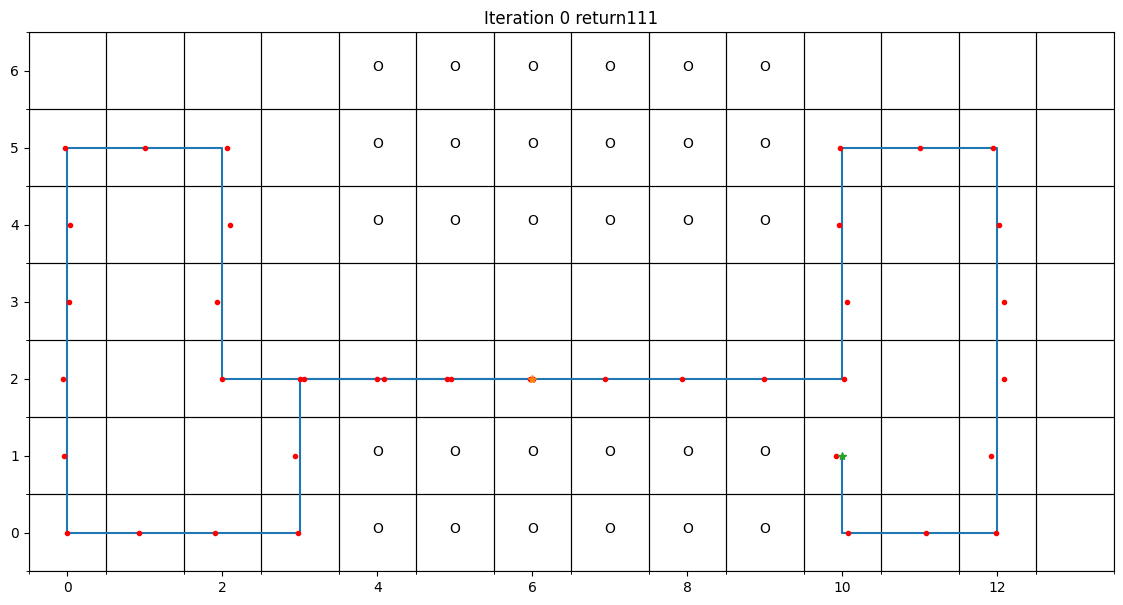

In [22]:
import importlib
import visualization
importlib.reload(visualization)
from visualization import Visu
visu = Visu(env_params=params["env"])
visu.visu_path(path,env.Hori_ActionTransitionMatrix)